In [3]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista
from typing import List, Tuple

import sys
import os
# Get the absolute path to the src directory
src_path = os.path.abspath('..')
if src_path not in sys.path:
    sys.path.append(src_path)

from src.visualization import timeDependentVariableToGif, plot_array, plot_function
from src.solutionOperators import solveStateEquation, solveAdjointEquation, getSourceTerm, buildControlFunction
from src.helpers import getValueOfFunction, buildIterationFunction
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import calculateL2InnerProduct, HesseMatrix
from src.semiSmoothNewtonSolver import computeSSNStep, computeObjective
from src.semiSmoothWalter import computeSSNStepWalter
from dataclasses import dataclass
from src.osqp import computeOSQPStep
from scipy import sparse

@dataclass
class Parameters:
    T = 1
    verbose = True
    
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 1e-8
    beta = 1e-8
    waveSpeed = 2
    randomFactor = 5
    maxIterations = 20
    pruneThreshold = 1e-9
    maxNewtonSteps = 50
    newton_c = 10
    useDummy = True
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

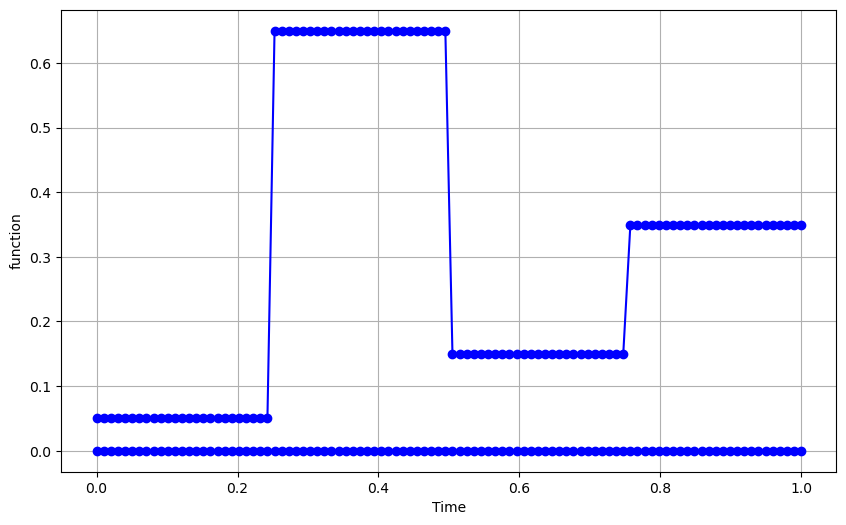

Upper bound objective value: 0.03159830202632312
Newton parameter:  1
Vector standard inner [-5.54356176e-02  1.27501920e-01  3.88049323e-02  7.21222984e-02
  4.59841655e-41  1.33045482e-01  8.48279326e-41]
Hesse: [[ 2.21742470e-01 -2.21742470e-01 -1.10871235e-01 -1.66866809e-01
  -1.06391936e-40 -2.21742470e-01 -1.41379888e-40]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.08303533e-01
   1.32811410e-40  3.32613706e-01  2.12069831e-40]
 [-1.10871235e-01  1.10871235e-01  1.10871235e-01  9.74322976e-02
   6.21214658e-41  1.10871235e-01  7.06899438e-41]
 [-1.66866809e-01  2.08303533e-01  9.74322976e-02  1.48574921e-01
   9.47292850e-41  2.21742470e-01  1.41379888e-40]
 [-1.06391936e-40  1.32811410e-40  6.21214658e-41  9.47292850e-41
   1.48574921e-01  1.41379888e-40  2.21742470e-01]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.21742470e-01
   1.41379888e-40  4.43484941e-01  2.82759775e-40]
 [-1.41379888e-40  2.12069831e-40  7.06899438e-41  1.41379888e-40
   2.21742470e-01 

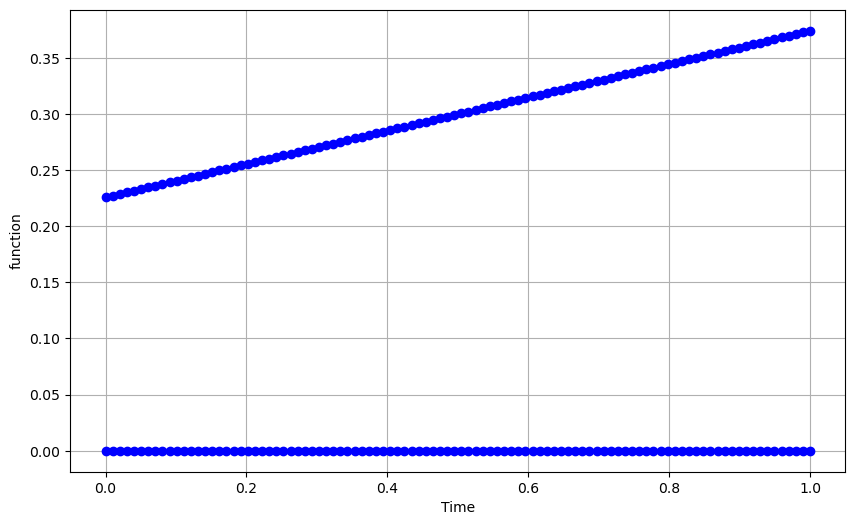

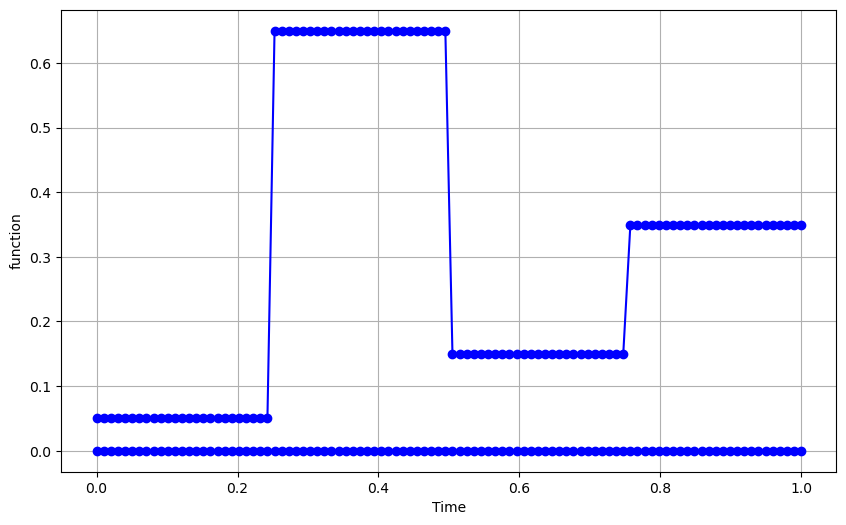

Upper bound objective value: 0.03159830202632312
Newton parameter:  1
Vector standard inner [-5.54356176e-02  1.27501920e-01  3.88049323e-02  7.21222984e-02
  4.59841655e-41  1.33045482e-01  8.48279326e-41]
Hesse: [[ 2.21742470e-01 -2.21742470e-01 -1.10871235e-01 -1.66866809e-01
  -1.06391936e-40 -2.21742470e-01 -1.41379888e-40]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.08303533e-01
   1.32811410e-40  3.32613706e-01  2.12069831e-40]
 [-1.10871235e-01  1.10871235e-01  1.10871235e-01  9.74322976e-02
   6.21214658e-41  1.10871235e-01  7.06899438e-41]
 [-1.66866809e-01  2.08303533e-01  9.74322976e-02  1.48574921e-01
   9.47292850e-41  2.21742470e-01  1.41379888e-40]
 [-1.06391936e-40  1.32811410e-40  6.21214658e-41  9.47292850e-41
   1.48574921e-01  1.41379888e-40  2.21742470e-01]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.21742470e-01
   1.41379888e-40  4.43484941e-01  2.82759775e-40]
 [-1.41379888e-40  2.12069831e-40  7.06899438e-41  1.41379888e-40
   2.21742470e-01 

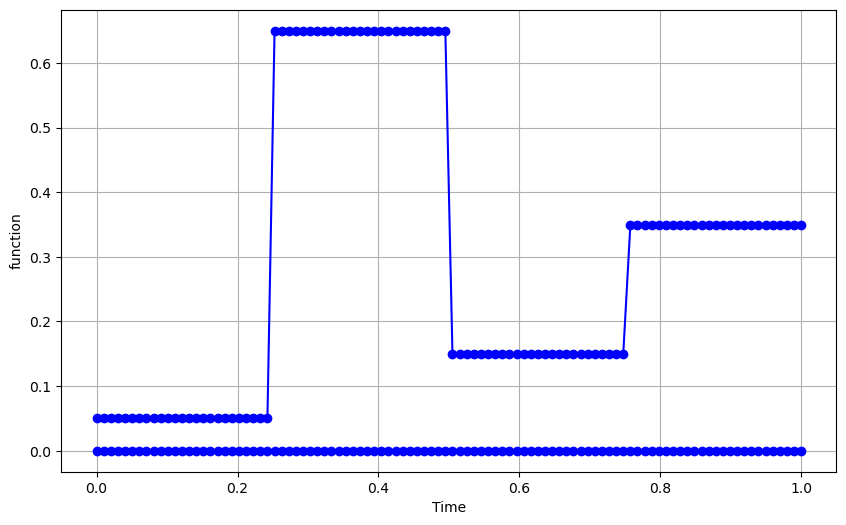

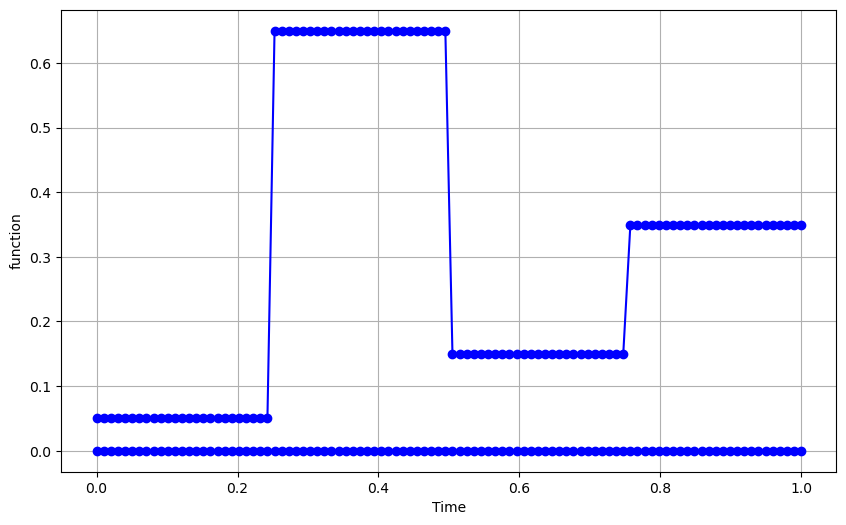

Upper bound objective value: 0.03159830202632312
Newton parameter:  1
Vector standard inner [-5.54356176e-02  1.27501920e-01  3.88049323e-02  7.21222984e-02
  4.59841655e-41  1.33045482e-01  8.48279326e-41]
Hesse: [[ 2.21742470e-01 -2.21742470e-01 -1.10871235e-01 -1.66866809e-01
  -1.06391936e-40 -2.21742470e-01 -1.41379888e-40]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.08303533e-01
   1.32811410e-40  3.32613706e-01  2.12069831e-40]
 [-1.10871235e-01  1.10871235e-01  1.10871235e-01  9.74322976e-02
   6.21214658e-41  1.10871235e-01  7.06899438e-41]
 [-1.66866809e-01  2.08303533e-01  9.74322976e-02  1.48574921e-01
   9.47292850e-41  2.21742470e-01  1.41379888e-40]
 [-1.06391936e-40  1.32811410e-40  6.21214658e-41  9.47292850e-41
   1.48574921e-01  1.41379888e-40  2.21742470e-01]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.21742470e-01
   1.41379888e-40  4.43484941e-01  2.82759775e-40]
 [-1.41379888e-40  2.12069831e-40  7.06899438e-41  1.41379888e-40
   2.21742470e-01 

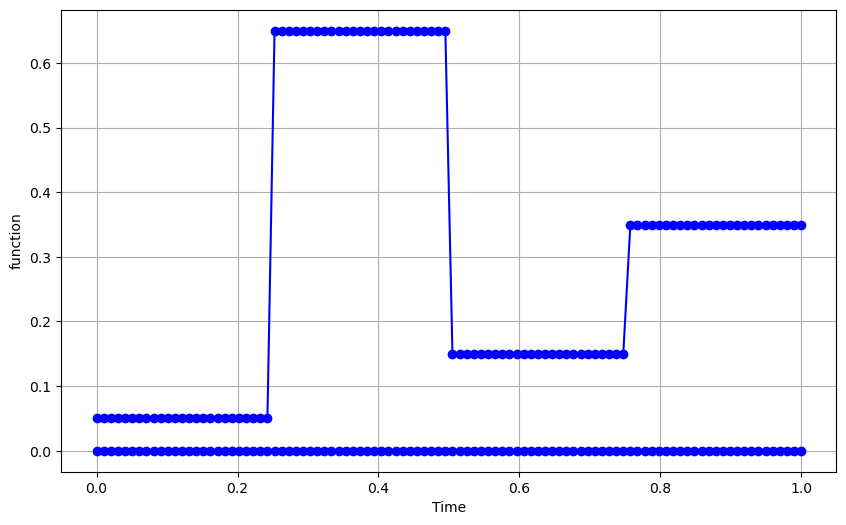

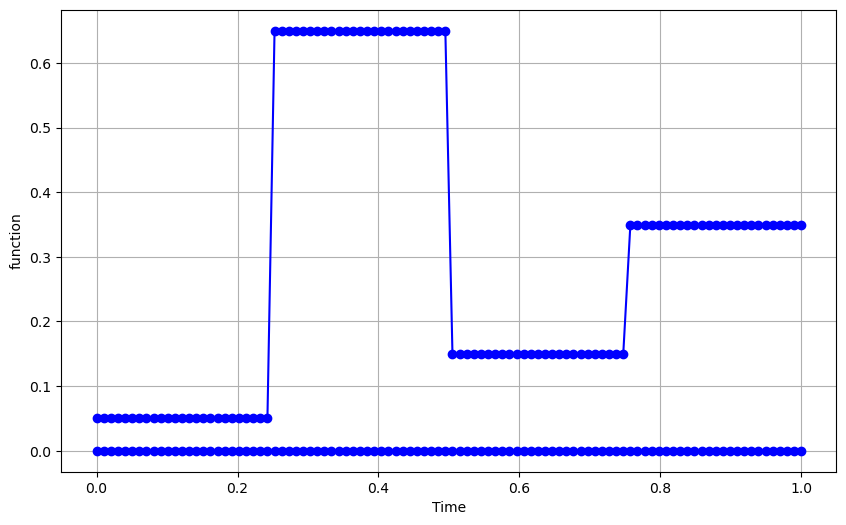

Upper bound objective value: 0.03159830202632312
Newton parameter:  1
Vector standard inner [-5.54356176e-02  1.27501920e-01  3.88049323e-02  7.21222984e-02
  4.59841655e-41  1.33045482e-01  8.48279326e-41]
Hesse: [[ 2.21742470e-01 -2.21742470e-01 -1.10871235e-01 -1.66866809e-01
  -1.06391936e-40 -2.21742470e-01 -1.41379888e-40]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.08303533e-01
   1.32811410e-40  3.32613706e-01  2.12069831e-40]
 [-1.10871235e-01  1.10871235e-01  1.10871235e-01  9.74322976e-02
   6.21214658e-41  1.10871235e-01  7.06899438e-41]
 [-1.66866809e-01  2.08303533e-01  9.74322976e-02  1.48574921e-01
   9.47292850e-41  2.21742470e-01  1.41379888e-40]
 [-1.06391936e-40  1.32811410e-40  6.21214658e-41  9.47292850e-41
   1.48574921e-01  1.41379888e-40  2.21742470e-01]
 [-2.21742470e-01  3.32613706e-01  1.10871235e-01  2.21742470e-01
   1.41379888e-40  4.43484941e-01  2.82759775e-40]
 [-1.41379888e-40  2.12069831e-40  7.06899438e-41  1.41379888e-40
   2.21742470e-01 

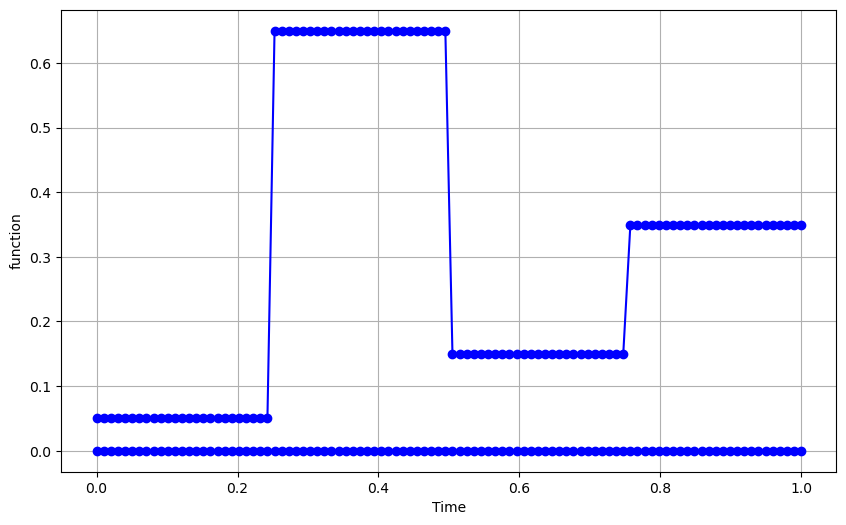

'\nparams_high = Parameters()\nparams_high.dt = 0.01\nparams_high.msh = mesh.create_rectangle(\n        comm=MPI.COMM_WORLD,\n        points=((-1., -1.), (1., 1.)),\n        n=(128, 128),\n        cell_type=mesh.CellType.triangle,\n    )\nparams_high.V = fem.functionspace(params_high.msh, ("Lagrange", 1))\nweights_high, slope_high, y_shift_high, hesseMatrix_high , active_set_high = example_solver(params_high)'

In [8]:
def example_solver(params):
    # Setup observation
    active_set = []
    active_set.append(ExtremalPoint(np.array([1, 0]), 0.5, type=0, params=params))
    active_set.append(ExtremalPoint(np.array([1, 0]), 0.2, type=0, params=params))
    weights = np.ones(len(active_set))
    slope = np.zeros((params.d,))
    y_shift = np.ones((params.d,))
    #u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
    u_1 = lambda t: (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)))
    u_2 = lambda t: (0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)))#buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
    array = np.ndarray((int(params.T/params.dt), 2))
    timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
    array[:, 0] = np.array([u_1(t) for t in timePoints])
    array[:, 1] = np.array([u_2(t) for t in timePoints])
    plot_array(array, params.T)
    g1 = getSourceTerm(params.x1, params)
    g2 = getSourceTerm(params.x2, params)
    control = buildControlFunction([g1, g2], [u_1, u_2], params)
    if not params.useDummy:
        yd = solveStateEquation(control, params)
    else:
        yd = control
    params.yd = yd

    #plot_function(lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params), params.T, params.dt)

    # Setup solver
    params.newton_c = 1
    params.maxNewtonSteps = 40
    slope = np.zeros((params.d,))
    y_shift = np.zeros((params.d,))
    active_set = []
    active_set.append(ExtremalPoint(np.array([-1, 0]), 0.5, type=0, params=params))
    active_set.append(ExtremalPoint(np.array([1, 0]), 0.25, type=0, params=params))
    active_set.append(ExtremalPoint(np.array([1, 0]), 0.75, type=0, params=params))
    weights = np.zeros(len(active_set))
    hesseMatrix = HesseMatrix(active_set, params)
    print('Upper bound objective value:', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesseMatrix.standard_states, params))
    #print('cond: ', np.linalg.cond(hesseMatrix.matrix))
    #timeDependentVariableToGif(params.yd, 'output/observation.gif', slowMoFactor=2, T=params.T)
    #weights[:] = 0
    print('Newton parameter: ', params.newton_c)
    #print(hesseMatrix.matrix)
    weights, slope, y_shift = computeSSNStepWalter(weights, slope, y_shift, active_set, hesseMatrix, params)
    #weights_new, slope_new, y_shift_new = computeOSQPStep(weights, slope, y_shift, active_set, hesseMatrix, params)
    print(f'weights with dt={params.dt}: ', np.concatenate((weights, slope, y_shift)))
    print('Objective:', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesseMatrix.standard_states, params))
    return weights, slope, y_shift, hesseMatrix, active_set

params_low = Parameters()
params_low.dt = 0.01
params_low.msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
params_low.V = fem.functionspace(params_low.msh, ("Lagrange", 1))
params_low.alpha = 1e-1
params_low.beta = 1e-8
weights_low, slope_low, y_shift_low, hesseMatrix_low , active_set_low = example_solver(params_low)
plot_function(lambda t: buildIterationFunction(t, active_set_low, weights_low, slope_low, y_shift_low, params_low), params.T, params.dt)
params_low.alpha = 1e-5
params_low.beta = 1e-8
weights_low, slope_low, y_shift_low, hesseMatrix_low , active_set_low = example_solver(params_low)
plot_function(lambda t: buildIterationFunction(t, active_set_low, weights_low, slope_low, y_shift_low, params_low), params.T, params.dt)
params_low.alpha = 1e-7
params_low.beta = 1e-8
weights_low, slope_low, y_shift_low, hesseMatrix_low , active_set_low = example_solver(params_low)
plot_function(lambda t: buildIterationFunction(t, active_set_low, weights_low, slope_low, y_shift_low, params_low), params.T, params.dt)
params_low.alpha = 1e-9
params_low.beta = 1e-8
weights_low, slope_low, y_shift_low, hesseMatrix_low , active_set_low = example_solver(params_low)
plot_function(lambda t: buildIterationFunction(t, active_set_low, weights_low, slope_low, y_shift_low, params_low), params.T, params.dt)
'''
params_high = Parameters()
params_high.dt = 0.01
params_high.msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(128, 128),
        cell_type=mesh.CellType.triangle,
    )
params_high.V = fem.functionspace(params_high.msh, ("Lagrange", 1))
weights_high, slope_high, y_shift_high, hesseMatrix_high , active_set_high = example_solver(params_high)'''

# walter semismooth objective: 8.281420269782905e-07
# osqp:  4.442877583256717e-06

In [3]:
#print(computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesseMatrix.standard_states, params))
#print(computeObjective(np.concatenate((weights_new, slope_new, y_shift_new)), active_set, hesseMatrix.standard_states, params))
#print('Objective: ',computeObjective(np.concatenate((weights_high, slope_high, y_shift_high)), active_set_high, hesseMatrix_high.standard_states, params_high))
#print('norms:')
#for state in hesseMatrix_high.standard_states: 
#    print(calculateL2InnerProduct(state, state, params_high))
print('Objective: ', computeObjective(np.concatenate((weights_low, slope_low, y_shift_low)), active_set_low, hesseMatrix_low.standard_states, params_low))
print('norms:')
for state in hesseMatrix_low.standard_states: 
    print(calculateL2InnerProduct(state, state, params_low))

Objective:  1.999997299321846e-09
norms:
6.835179001986232e-05
6.835179001986422e-05
0.0006788844680687646
0.0006788844680687952
